In [ ]:
# analyze the embedding of brain models and random models
# ! one problem, may be the model have seen the random vectors before! 

# load brain model
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModel, LlamaForCausalLM, LlamaTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained('/home/yzy/.cache/huggingface/hub/models--gpt2-xl/snapshots/33cdb5c0db5423c1879b1b9f16c352988e8754a8')
model = GPT2LMHeadModel.from_pretrained('/home/yzy/.cache/huggingface/hub/models--gpt2-xl/snapshots/33cdb5c0db5423c1879b1b9f16c352988e8754a8')
device = torch.device(f'cuda:{args["cuda"]}')
model.to(device)


In [17]:
# analyze the embedding of brain models and random models
# ! one problem, may be the model have seen the random vectors before! 

# load brain model
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModel, LlamaForCausalLM, LlamaTokenizer
from model_utils import Encoding_model
from data import FMRI_dataset
import pickle
import torch


def get_vectors(checkpoint_path, task_name, input_dataset,random_input=False):
    args = {
        'model_name': 'gpt2-xl',
        'cuda': '0',
        'load_check_point': True,
        'roi_selected': [],
        'enable_grad': False,
        'word_embed_size':1600,
        'brain_embed_size':1000,
        'method': 'decoding',
        'task_name': task_name,
        'add_end': False,
        'data_splitting': 'trail_id',
        'test_trail_ids': [1,2],
        'mode': 'evaluate',
        'random_input': random_input,
        'fmri_pca': True
    }
    encoding_model = Encoding_model(args)
    check_point = torch.load(checkpoint_path+'/model.pt')
    encoding_model.load_state_dict(check_point['encoding_model'])

    global tokenizer, model, device

    input_dataset = FMRI_dataset(input_dataset, args, tokenizer=tokenizer)
    vectors = []
    for item in input_dataset.test:
        item['additional_bs'].to(device)
        vectors.append(encoding_model(item['additional_bs']).squeeze().detach().cpu().tolist())
    return vectors





In [57]:
vec1 = get_vectors(checkpoint_path = '../results/Pereira_M02_gpt2-xl_lr1e-5_tid1,2', task_name = 'Pereira_M02', input_dataset = pickle.load(open(f'../../dataset/preprocessed/Pereira/M02.wq.pkl','rb')))
vec2 = get_vectors(checkpoint_path = '../results/Pereira_M02_gpt2-xl_lr1e-5_tid1,2_random', task_name = 'Pereira_M02', input_dataset = pickle.load(open(f'../../dataset/preprocessed/Pereira/M02.wq.pkl','rb')), random_input=True)


In [54]:
vec1 = get_vectors(checkpoint_path = '../results/Pereira_M02_gpt2-xl_lr1e-5_tid1,2_a0.1f0.25', task_name = 'Pereira_M02', input_dataset = pickle.load(open(f'../../dataset/preprocessed/Pereira/M02.wq.pkl','rb')))
vec2 = get_vectors(checkpoint_path = '../results/Pereira_P01_gpt2-xl_lr1e-5_tid1,2_a0.1f0.25_random', task_name = 'Pereira_P01', input_dataset = pickle.load(open(f'../../dataset/preprocessed/Pereira/P01.wq.pkl','rb')), random_input=True)


In [49]:
model_dict = torch.load('../../history/decoding0710/results/HP_H_gpt2-xl_lr1e-5_a0.1f0.25/model.pt')

In [50]:
model_dict.keys()

dict_keys(['new_tokens'])

In [24]:
import copy
vec3 = copy.deepcopy(model.transformer.wte.weight.detach().cpu().numpy())

In [27]:
import numpy as np
random_indices = np.random.choice(vec3.shape[0], size=2000, replace=False)
random_vectors = vec3[random_indices]
random_vectors.shape

(2000, 1600)

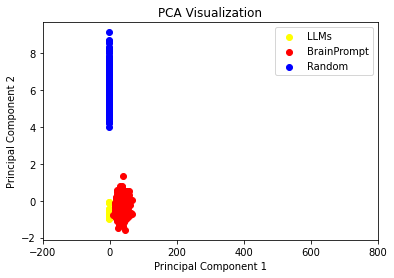

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

data = np.vstack((vec1, vec2, random_vectors))

# 使用PCA进行降维
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# 将降维后的数据分割回两组
reduced_group1 = reduced_data[:250]
reduced_group2 = reduced_data[250:500]
reduced_group3 = reduced_data[500:]
plt.cla()
plt.scatter(reduced_group3[:, 0], reduced_group3[:, 1], c='yellow', label='LLMs')
plt.scatter(reduced_group1[:, 0], reduced_group1[:, 1], c='red', label='BrainPrompt')
plt.scatter(reduced_group2[:, 0], reduced_group2[:, 1], c='blue', label='Random')
plt.legend()
plt.xlim(-200,800)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()



In [39]:
reduced_group1.shape

(250, 2)

In [37]:
reduced_group1[0]

array([680.98138543,  82.95155204])

In [38]:
reduced_group3[1000]

array([-57.17877047,  -0.05835567])

In [43]:
reduced_group3[1500]

array([-57.17248936,  -0.05742494])

In [33]:
np.array(vec1).shape

(250, 1600)

In [31]:
data.shape

(2500, 1600)

In [1]:
import torch
from model_utils import Encoding_model 
import pickle

model_path = '/home/yzy/fmri/history/decoding0907/results/HP_F_gpt2-xl_lr1e-4_random/model.pt'
# model_path = '/home/bingxing2/home/scx7140/fmri/decoding/results/HP_F_gpt2-xl_lr1e-5_b4_pos/model.pt'
checkpoint = torch.load(model_path, map_location='cpu')
encoding_model = Encoding_model({'brain_embed_size':1000,'word_embed_size':checkpoint['encoding_model']['linear.weight'].shape[0],'pos':True})
encoding_model.load_state_dict(checkpoint['encoding_model'])
data = pickle.load(open('/home/bingxing2/home/scx7140/fmri/dataset/preprocessed/HP/raw_F.pca1000.wq.pkl','rb'))['fmri_data'][0]
data_out1 = encoding_model(data)
encoding_model.MLP.position_index = False
data_out2 = encoding_model(data)

print(data_out1)
print(data_out2)


tensor([ 0.0274, -0.0184, -0.0071, -0.0296, -0.0276, -0.0106, -0.0220, -0.0145,
        -0.0288,  0.0286,  0.0129,  0.0097,  0.0415,  0.0086, -0.0400,  0.0526,
        -0.0255,  0.0100,  0.0262,  0.0082,  0.0168, -0.0444, -0.0214,  0.0229,
        -0.0008, -0.0246,  0.0250,  0.0212, -0.0530,  0.0402, -0.0222,  0.0540,
         0.0165, -0.0464, -0.0367, -0.0248,  0.0220,  0.0504,  0.0235, -0.0042,
        -0.0108, -0.0027,  0.0291,  0.0190,  0.0541,  0.0218,  0.0132,  0.0182,
        -0.0085, -0.0160, -0.0160,  0.0353,  0.0107,  0.0451, -0.0253,  0.0108,
         0.0168, -0.0129,  0.0375,  0.0192,  0.0559, -0.0543, -0.0113, -0.0245,
        -0.0109,  0.0500,  0.0241, -0.0082,  0.0261, -0.0097,  0.0198,  0.0398,
         0.0094,  0.0289, -0.0157, -0.0061, -0.0437, -0.0348,  0.0280, -0.0220,
        -0.0107,  0.0378,  0.0212,  0.0072,  0.0354, -0.0478,  0.0162,  0.0385,
        -0.0300,  0.0080, -0.0459,  0.0226,  0.0201,  0.0455,  0.0058, -0.0404,
         0.0104, -0.0131,  0.0137, -0.03

RuntimeError: Error(s) in loading state_dict for Encoding_model:
	Missing key(s) in state_dict: "mlp.position_embedding". 